MOVIE Recommentation System

# Importing Data and Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_movies = pd.read_csv('/content/drive/MyDrive/tmdb_5000_movies.csv')
data_credits=pd.read_csv('/content/drive/MyDrive/tmdb_5000_credits.csv')
movies_data = pd.read_csv('/content/drive/MyDrive/movies.csv')


In [ ]:
print("data_movie columns: ",data_movies.columns)
print()
print("data_credits columns: ",data_credits.columns)
print()
print("movies_data columns: ",movies_data.columns)

data_movie columns:  Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

data_credits columns:  Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

movies_data columns:  Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')


# Data Cleaning and Preprocessing

In [ ]:
data_movies = data_movies.merge(data_credits,on='title')
data_movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [ ]:
data_movies = data_movies[['genres','id','tagline','keywords' ,"title",'budget', 'overview', "cast",'revenue','release_date','runtime','vote_average',"popularity",'production_companies']]
data_movies.head(3)

,genres,id,tagline,keywords,title,budget,overview,cast,revenue,release_date,runtime,vote_average,popularity,production_companies
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,Enter the World of Pandora.,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Avatar,237000000,"In the 22nd century, a paraplegic Marine is di...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...",2787965087,2009-12-10,162.0,7.2,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"At the end of the world, the adventure begins.","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Pirates of the Caribbean: At World's End,300000000,"Captain Barbossa, long believed to be dead, ha...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...",961000000,2007-05-19,169.0,6.9,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,A Plan No One Escapes,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",Spectre,245000000,A cryptic message from Bond’s past sends him o...,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...",880674609,2015-10-26,148.0,6.3,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam..."


In [ ]:
features = ['cast', 'genres','production_companies','keywords']
for feature in features:
  data_movies[feature] = data_movies[feature].apply(literal_eval)
data_movies.head(3)

,genres,id,tagline,keywords,title,budget,overview,cast,revenue,release_date,runtime,vote_average,popularity,production_companies
0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,Enter the World of Pandora.,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",Avatar,237000000,"In the 22nd century, a paraplegic Marine is di...","[{'cast_id': 242, 'character': 'Jake Sully', '...",2787965087,2009-12-10,162.0,7.2,150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"At the end of the world, the adventure begins.","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",Pirates of the Caribbean: At World's End,300000000,"Captain Barbossa, long believed to be dead, ha...","[{'cast_id': 4, 'character': 'Captain Jack Spa...",961000000,2007-05-19,169.0,6.9,139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'..."
2,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,A Plan No One Escapes,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",Spectre,245000000,A cryptic message from Bond’s past sends him o...,"[{'cast_id': 1, 'character': 'James Bond', 'cr...",880674609,2015-10-26,148.0,6.3,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam..."


In [ ]:
def get_str(meta_data):
    if isinstance(meta_data, list):
        names = [col['name'] for col in meta_data]
        str=""
        for i in names:
          str=str+ " "+i
        return str
    return " "
def get_list(meta_data):
    if isinstance(meta_data, list):
        names = [col['name'] for col in meta_data]
        mlist=[]
        for i in names:
          mlist.append(i)
        return mlist
    return []
data_movies['genre_list']=data_movies['genres'].apply(get_list)
features = ['cast','genres','production_companies','keywords']
for feature in features:
    data_movies[feature] = data_movies[feature].apply(get_str)

In [ ]:
data_movies.isnull().sum()

genres                    0
id                        0
tagline                 844
keywords                  0
title                     0
budget                    0
overview                  3
cast                      0
revenue                   0
release_date              1
runtime                   2
vote_average              0
popularity                0
production_companies      0
genre_list                0
dtype: int64

In [ ]:
selected_features = ['genres','keywords','tagline','cast']
print(selected_features)
for feature in selected_features:
  data_movies[feature] =data_movies[feature].fillna('')
data_movies.isnull().sum()

['genres', 'keywords', 'tagline', 'cast']


genres                  0
id                      0
tagline                 0
keywords                0
title                   0
budget                  0
overview                3
cast                    0
revenue                 0
release_date            1
runtime                 2
vote_average            0
popularity              0
production_companies    0
genre_list              0
dtype: int64

In [ ]:
data_movies = data_movies.dropna()
data_movies.isnull().sum()

genres                  0
id                      0
tagline                 0
keywords                0
title                   0
budget                  0
overview                0
cast                    0
revenue                 0
release_date            0
runtime                 0
vote_average            0
popularity              0
production_companies    0
genre_list              0
dtype: int64

In [ ]:
data_movies.shape

(4805, 15)

In [ ]:
data_movies['profit']=data_movies['revenue']-data_movies['budget']
data_movies['profit_percent']=data_movies['profit']*100/data_movies['budget']
data_movies.head()

,genres,id,tagline,keywords,title,budget,overview,cast,revenue,release_date,runtime,vote_average,popularity,production_companies,genre_list,profit,profit_percent
0,Action Adventure Fantasy Science Fiction,19995,Enter the World of Pandora.,culture clash future space war space colony s...,Avatar,237000000,"In the 22nd century, a paraplegic Marine is di...",Sam Worthington Zoe Saldana Sigourney Weaver ...,2787965087,2009-12-10,162.0,7.2,150.437577,Ingenious Film Partners Twentieth Century Fox...,"[Action, Adventure, Fantasy, Science Fiction]",2550965087,1076.356577
1,Adventure Fantasy Action,285,"At the end of the world, the adventure begins.",ocean drug abuse exotic island east india tra...,Pirates of the Caribbean: At World's End,300000000,"Captain Barbossa, long believed to be dead, ha...",Johnny Depp Orlando Bloom Keira Knightley Ste...,961000000,2007-05-19,169.0,6.9,139.082615,Walt Disney Pictures Jerry Bruckheimer Films ...,"[Adventure, Fantasy, Action]",661000000,220.333333
2,Action Adventure Crime,206647,A Plan No One Escapes,spy based on novel secret agent sequel mi6 br...,Spectre,245000000,A cryptic message from Bond’s past sends him o...,Daniel Craig Christoph Waltz Léa Seydoux Ralp...,880674609,2015-10-26,148.0,6.3,107.376788,Columbia Pictures Danjaq B24,"[Action, Adventure, Crime]",635674609,259.459024
3,Action Crime Drama Thriller,49026,The Legend Ends,dc comics crime fighter terrorist secret iden...,The Dark Knight Rises,250000000,Following the death of District Attorney Harve...,Christian Bale Michael Caine Gary Oldman Anne...,1084939099,2012-07-16,165.0,7.6,112.312950,Legendary Pictures Warner Bros. DC Entertainm...,"[Action, Crime, Drama, Thriller]",834939099,333.975640
4,Action Adventure Science Fiction,49529,"Lost in our world, found in another.",based on novel mars medallion space travel pr...,John Carter,260000000,"John Carter is a war-weary, former military ca...",Taylor Kitsch Lynn Collins Samantha Morton Wi...,284139100,2012-03-07,132.0,6.1,43.926995,Walt Disney Pictures,"[Action, Adventure, Science Fiction]",24139100,9.284269


In [ ]:
profit_percent=pd.DataFrame(data_movies['profit_percent'])
profit_percent=profit_percent.to_numpy()
runtime=pd.DataFrame(data_movies['runtime'])
runtime=runtime.to_numpy()
vote_average=pd.DataFrame(data_movies['vote_average'])
vote_average=vote_average.to_numpy()
popularity=pd.DataFrame(data_movies['popularity'])
popularity=popularity.to_numpy()
original_title=pd.DataFrame(data_movies['title'])
original_title=original_title.to_numpy()
original_title.shape

(4805, 1)

In [ ]:
def getlist1(nump):
  t=[]
  for i in range(4799):
    a=nump[i]
    a=a[0]
    t.append(a)
  t=np.array(t)
  return t
profit_percent=getlist1(profit_percent)
runtime=getlist1(runtime)
vote_average=getlist1(vote_average)
popularity=getlist1(popularity)
original_title=getlist1(original_title)
original_title

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       ..., 'Sanctuary: Quite a Conundrum', 'Bang', 'Primer'],
      dtype='<U86')

In [ ]:
movie_genre=pd.DataFrame(data_movies['genre_list'])
movie_genre=movie_genre.to_numpy()
def getlist(nump):
  t={'aa'}
  for i in range(4799):
    a=nump[i]
    a=a[0]
    for j in a:
      t.add(j)
  t=list(t)
  t.sort()
  t.remove('aa')
  t=np.array(t)
  return t

moviegenre=getlist(movie_genre)
moviegenre

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype='<U15')

In [ ]:
genre_onehot=[]
def onehot(gen):
  t=[]
  for j in range(4805):
    c=movie_genre[j]
    c=c[0]
    o=5
    e=0
    print
    for k in c:
      if k==gen:
        e=o
      o=o-1
    t.append(e)
  t=np.array(t)
  return t



for i in moviegenre:
  y=onehot(i)
  genre_onehot.append(y)
genre_onehot=np.array(genre_onehot)
genre_onehot=genre_onehot.reshape(4805,20)
genre_onehot.shape

(4805, 20)

In [ ]:
combined_features = data_movies['genres']+' '+data_movies['keywords']+' '+data_movies['tagline']+' '+data_movies['cast']
print(combined_features)

0        Action Adventure Fantasy Science Fiction  cul...
1        Adventure Fantasy Action  ocean drug abuse ex...
2        Action Adventure Crime  spy based on novel se...
3        Action Crime Drama Thriller  dc comics crime ...
4        Action Adventure Science Fiction  based on no...
                              ...                        
4804     Action Crime Thriller  united states–mexico b...
4805     Comedy Romance  A newlywed couple's honeymoon...
4806     Comedy Drama Romance TV Movie  date love at f...
4807      A New Yorker in Shanghai  Daniel Henney Eliz...
4808     Documentary  obsession camcorder crush dream ...
Length: 4805, dtype: object


In [ ]:
t=[]
for i in range(4805):
  t.append(i)
data_movies['index'] = np.array(t)

# Data Visualization

<BarContainer object of 100 artists>

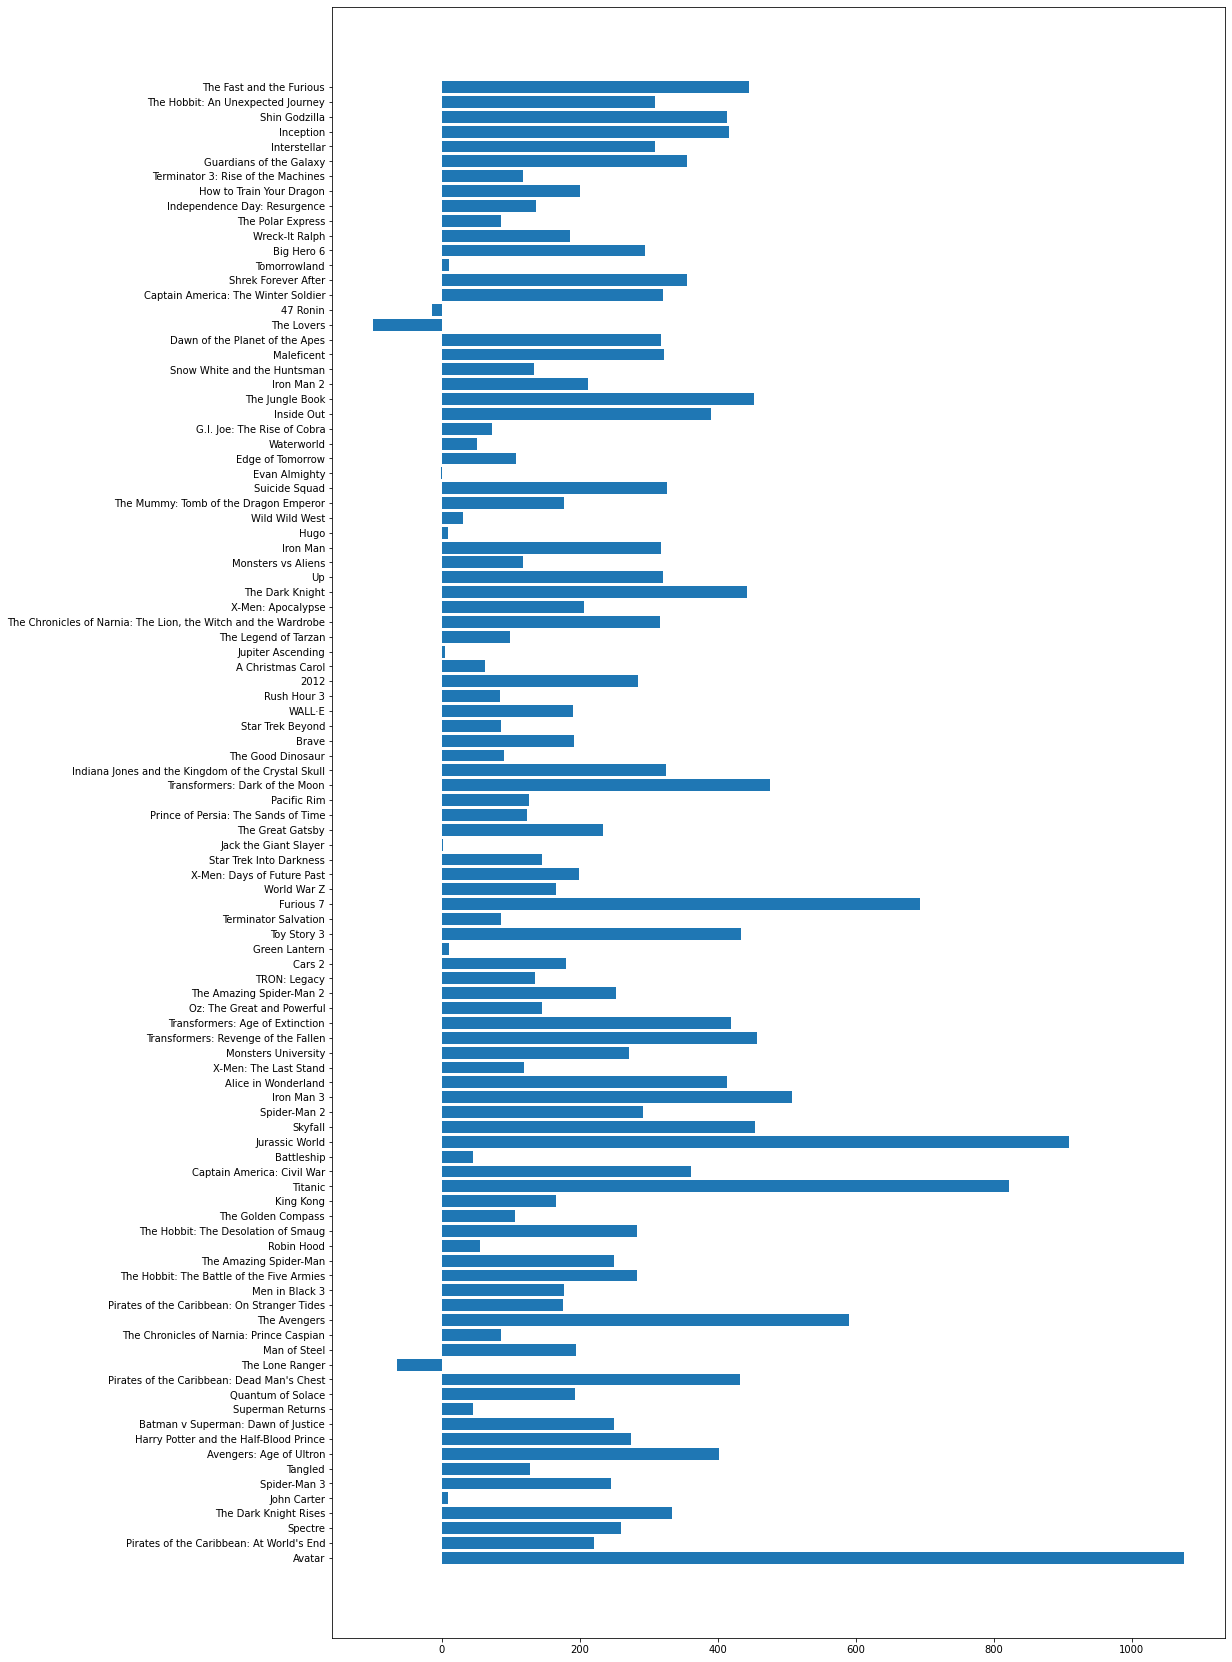

In [ ]:
x=original_title[0:100]
y=profit_percent[0:100]
x=x.tolist()
y=y.tolist()
fig, ax = plt.subplots(figsize =(16, 30))
ax.barh(x, y)

# Recommendation System

In [ ]:
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)
print(feature_vectors)

  (0, 32153)	0.06329759928427837
  (0, 19542)	0.08214693908620008
  (0, 42558)	0.09388897259137212
  (0, 27969)	0.09388897259137212
  (0, 41457)	0.09388897259137212
  (0, 32412)	0.03106738284939261
  (0, 2765)	0.05529526710306288
  (0, 40282)	0.08648057428552612
  (0, 964)	0.05701530043839404
  (0, 37003)	0.06329759928427837
  (0, 35064)	0.07566852355451548
  (0, 32358)	0.08955533739204605
  (0, 33169)	0.07566852355451548
  (0, 14359)	0.07309096914289213
  (0, 31547)	0.09388897259137212
  (0, 30576)	0.08214693908620008
  (0, 37156)	0.05125447377000997
  (0, 30342)	0.09388897259137212
  (0, 23063)	0.056681271393996646
  (0, 29258)	0.09388897259137212
  (0, 19730)	0.06826012524866948
  (0, 28208)	0.07907217597968012
  (0, 38364)	0.04718805397615225
  (0, 17869)	0.05165784464091842
  (0, 26046)	0.0723535692275863
  :	:
  (4803, 27793)	0.15377031427246002
  (4803, 4071)	0.1405948826775975
  (4803, 33169)	0.2947243935634339
  (4804, 17076)	0.3424954323476423
  (4804, 6144)	0.279745496311256

In [ ]:
similarity = cosine_similarity(feature_vectors)
list_of_all_titles = data_movies['title'].tolist()
print(list_of_all_titles)

['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2', 'TRON: Legacy', 'Cars 2', 'Green Lant

In [ ]:
movie_name = input(' Enter your favourite movie name : ')

list_of_all_titles = data_movies['title'].tolist()

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

close_match = find_close_match[0]
print(close_match)

index_of_the_movie = data_movies[data_movies.title == close_match]['index'].values[0]
print(index_of_the_movie)
similarity_score = list(enumerate(similarity[index_of_the_movie]))

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  if (i<16):
    title_from_index = data_movies[data_movies.index==index]['title'].values[0]
    tagline_from_index = data_movies[data_movies.index==index]['tagline'].values[0]
    if tagline_from_index!='':
      print(i, '.',title_from_index,'-',tagline_from_index)
    else:
      print(i, '.',title_from_index)
    i+=1

 Enter your favourite movie name : batman
Batman
1362
Movies suggested for you : 

1 . Batman - Have you ever danced with the devil in the pale moonlight?
2 . Batman - He's Here Big As Life In A Real Bat-Epic
3 . Batman - Have you ever danced with the devil in the pale moonlight?
4 . Batman & Robin - Strength. Courage. Honor. And loyalty.
5 . Batman Returns - The Bat, the Cat, the Penguin.
6 . Batman Forever - Courage now, truth always...
7 . Superman III - If the world's most powerful computer can control even Superman...no one on earth is safe.
8 . Superman IV: The Quest for Peace - Nuclear Power. In the best hands, it is dangerous. In the hands of Lex Luthor, it is pure evil. This is Superman's greatest battle. And it is for all of us.
9 . Man of Steel - You will believe that a man can fly.
10 . The Dark Knight - Why So Serious?
11 . Superman Returns
12 . 2:13 - Killers Are Not Born ... They Are Made
13 . Batman Begins - Evil fears the knight.
14 . Superman - You'll Believe a Man Ca

# Revenue Prediction